In [372]:
import sys

import bioinfoLib as binf
import scanpy as sc
import scvi

# from scvi.external import SysVI

sc.set_figure_params(figsize=(5, 5))

sys.path.append("../models")
from sysvi import SysVI

simulate_new_data = True
if simulate_new_data:
    import ipynbname

    ro = binf.R.utils.start_r_session()
    splat_func = binf.R.utils.splatter_helper(ro)

    import os

    # I dont know why working directory was in the bioinfoLib/R
    os.chdir(str(ipynbname.path().parent))
    test_data = binf.R.utils.splatter_simulate_loop(
        splat_func, ro, 0.05, 0.1, [1000, 1000, 1000], 10
    )
    test_data.write_h5ad("../data/adata_test_scvi.h5ad")

- renv activated -- please restart the R session.
- Activated Python 3.12.11 [virtualenv; ~/Git/vae/.venv]
- renv activated -- please restart the R session.


R callback write-console: Getting parameters...
  
R callback write-console: Creating simulation object...
  
R callback write-console: Simulating library sizes...
  
R callback write-console: Simulating gene means...
  
R callback write-console: Simulating batch effects...
  
R callback write-console: Simulating path steps...
  


[1] 10


R callback write-console: Simulating BCV...
  
R callback write-console: Simulating counts...
  
R callback write-console: Simulating dropout (if needed)...
  
R callback write-console: Sparsifying assays...
  
R callback write-console: Automatically converting to sparse matrices, threshold = 0.95
  
R callback write-console: Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix
  
R callback write-console: Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix
  
R callback write-console: Skipping 'BCV': estimated sparse size 1.5 * dense matrix
  
R callback write-console: Skipping 'CellMeans': estimated sparse size 1.49 * dense matrix
  
R callback write-console: Skipping 'TrueCounts': estimated sparse size 1.68 * dense matrix
  
R callback write-console: Skipping 'counts': estimated sparse size 1.68 * dense matrix
  
R callback write-console: Done!
  


# synthetic

In [469]:
adata = sc.read_h5ad("../data/adata_test_scvi.h5ad")

In [470]:
binf.scr.qc.normalize_and_select_hvg(adata, n_top_genes=2000, batch_key="Batch")

counts layer is not available and X is not log1p transformed. Copy X to counts before normalization
no raw in adata, so save X to raw before computing hvg


In [471]:
# sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


In [473]:
sc.tl.diffmap(adata)

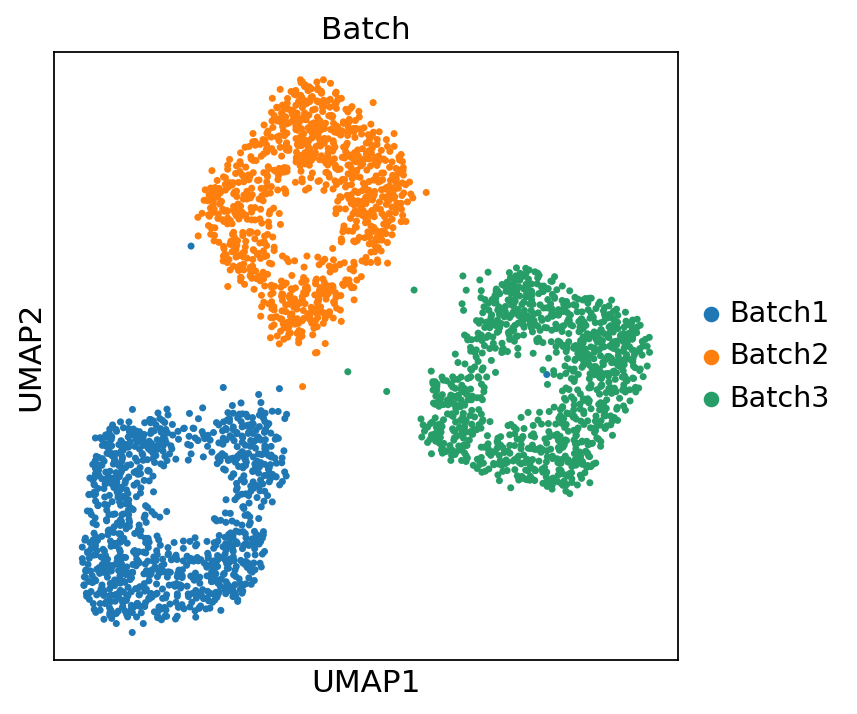

In [472]:
sc.pl.umap(adata, color="Batch")

In [394]:
import numpy as np
from scipy.sparse import csr_matrix

np.random.seed(1)
adata_reorder = adata[np.random.permutation(adata.shape[0]), :].copy()
adata_reorder.X = adata_reorder.layers["counts"].copy()
sc.pp.normalize_total(adata_reorder, target_sum=1e4)
adata_reorder.X = csr_matrix(adata_reorder.X.round())

In [395]:
adata_reorder

AnnData object with n_obs × n_vars = 3000 × 500
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'diffmap_evals', 'Batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [453]:
scvi.settings.seed = 1  # sysvi performance depends on random seed, perhaps due to vamp prior initialization??
scvi.external.SysVI.setup_anndata(adata_reorder, batch_key="Batch")
model = scvi.external.SysVI(
    adata_reorder,
    prior="standard_normal",
    n_prior_components=16,
    n_latent=20,
    n_hidden=128,
    n_layers=2,
    out_var_mode="feature",
    encoder_decoder_kwargs={
        "inject_covariates": False,
        "use_layer_norm": False,
        "use_batch_norm": False,
        "bias": True,
    },
)
model.train(
    max_epochs=200,
    plan_kwargs={
        "z_distance_cycle_weight": 0,  # default is 2
        # "lr": 1e-3,
    },
    check_val_every_n_epoch=1,
    batch_size=int(adata_reorder.shape[0] / 2),
)
adata_reorder.obsm["scvi"] = model.get_latent_representation()

Seed set to 1


INFO     The model has been initialized                                                                            


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


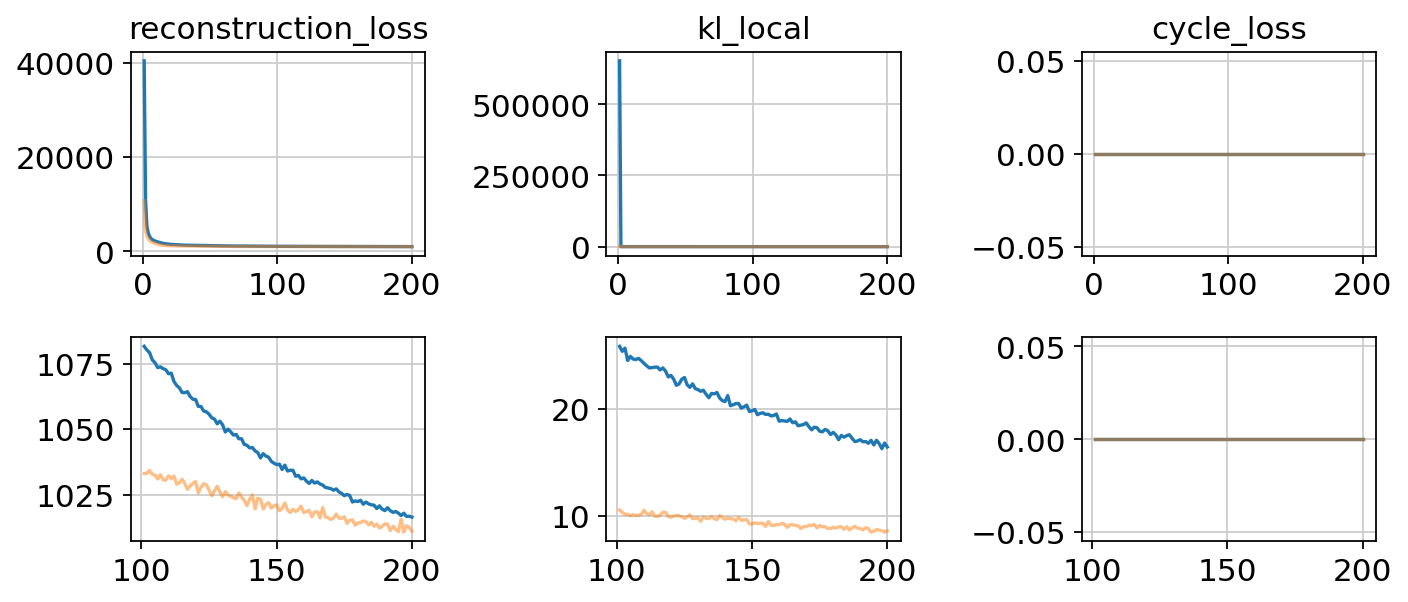

In [391]:
import matplotlib.pyplot as plt

epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(
            l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha
        )

fig.tight_layout()

In [24]:
SCVI.setup_anndata(adata, batch_key="Batch")
model = SCVI(adata, gene_likelihood="nb", n_hidden=256, n_latent=30)
model.train(max_epochs=200)
adata.obsm["scvi"] = model.get_latent_representation()

/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [39]:
scvi.model.SCVI.setup_anndata(adata, batch_key="Batch")
model = scvi.model.SCVI(adata, gene_likelihood="nb")
model.train(max_epochs=200)
adata.obsm["scvi"] = model.get_latent_representation()

/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [459]:
sc.external.pp.bbknn(
    adata_reorder,
    batch_key="Batch",
    use_rep="scvi",
    key_added="nei_scvi",
    neighbors_within_batch=20,
)

consider updating your call to make use of `computation`


In [460]:
# sc.pp.neighbors(
#     adata_reorder, use_rep="scvi", key_added="nei_scvi", method="gauss", n_neighbors=20
# )
sc.tl.umap(adata_reorder, neighbors_key="nei_scvi", key_added="umap_scvi")

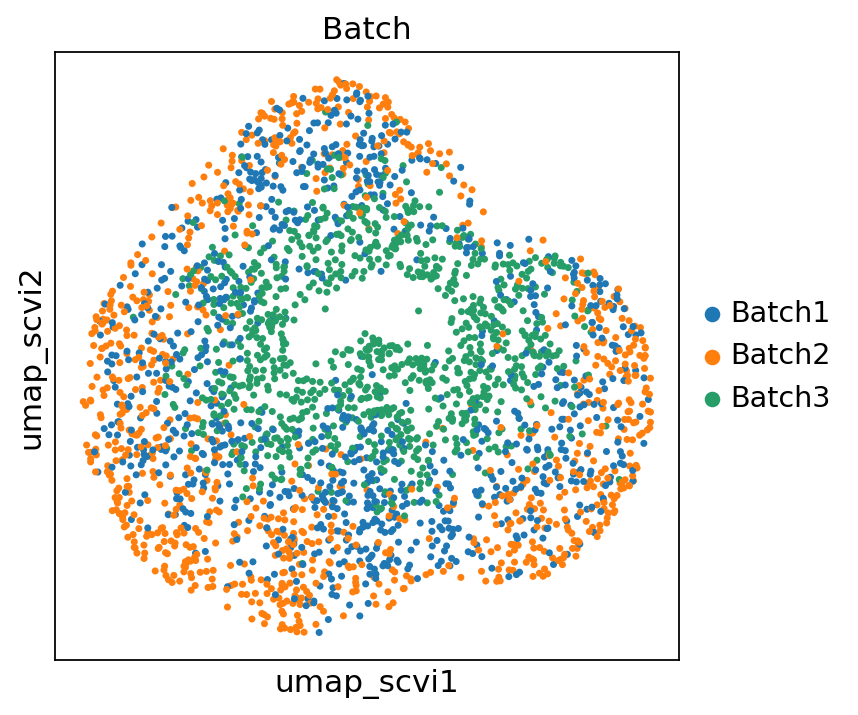

In [461]:
sc.pl.embedding(adata_reorder, basis="umap_scvi", color="Batch")

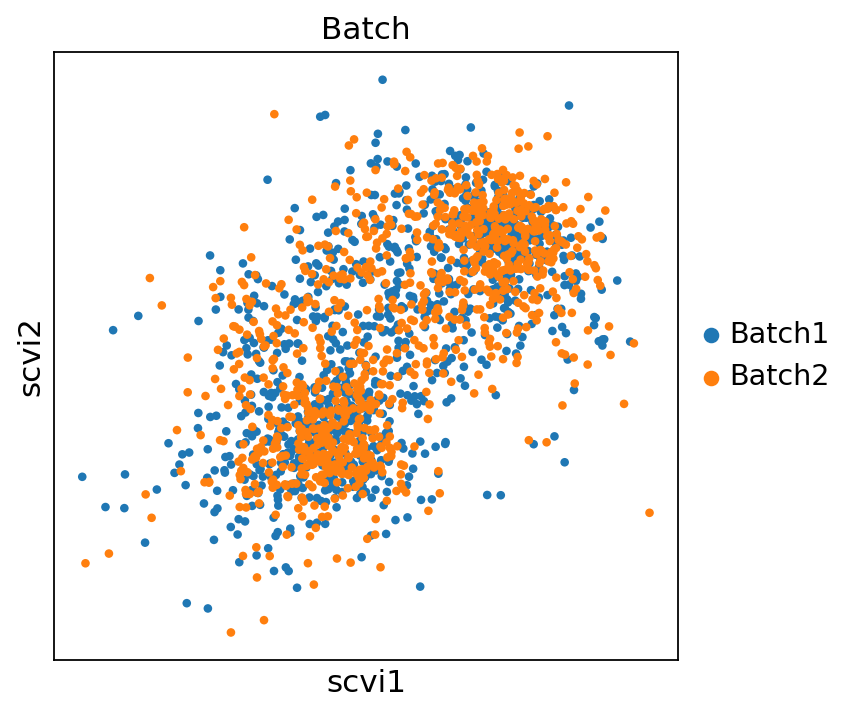

In [252]:
sc.pl.embedding(adata, basis="scvi", color="Batch", components=["1,2"])

In [342]:
adata_sub = adata[adata.obs["Batch"] == "Batch2"].copy()
sc.pp.neighbors(adata_sub)
sc.tl.diffmap(adata_sub)

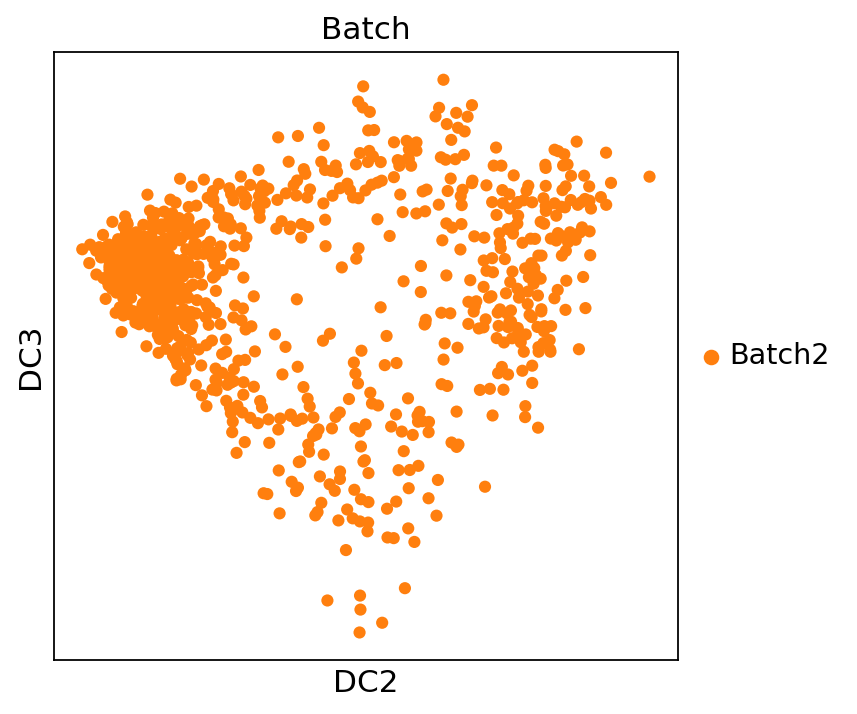

In [343]:
sc.pl.embedding(adata_sub, basis="diffmap", components=["2,3"], color="Batch")

In [462]:
sc.tl.diffmap(adata_reorder, neighbors_key="nei_scvi")

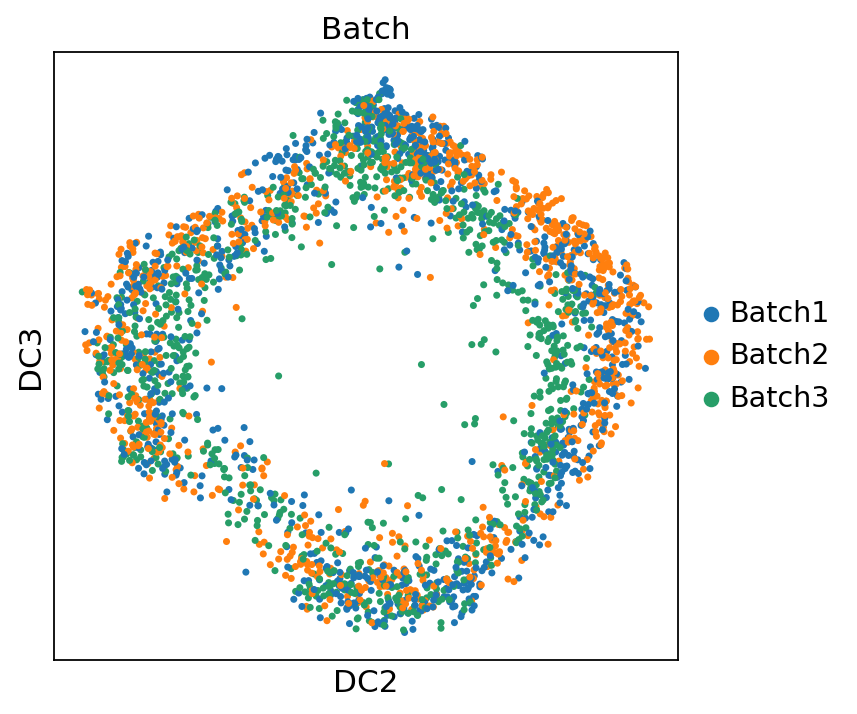

In [ ]:
sc.pl.embedding(
    adata_reorder, basis="diffmap", components=["2,3"], color="Batch", show=False
)
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/loop_1.png",
    dpi=300,
    bbox_inches="tight",
)

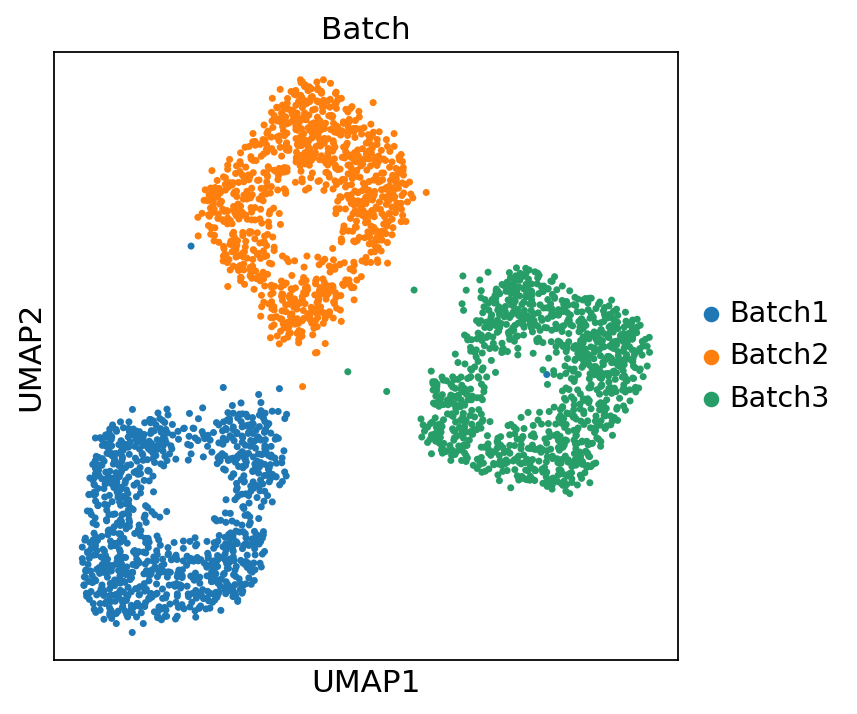

In [479]:
sc.pl.umap(adata, color="Batch", show=False)
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/loop_2.png",
    dpi=300,
    bbox_inches="tight",
)

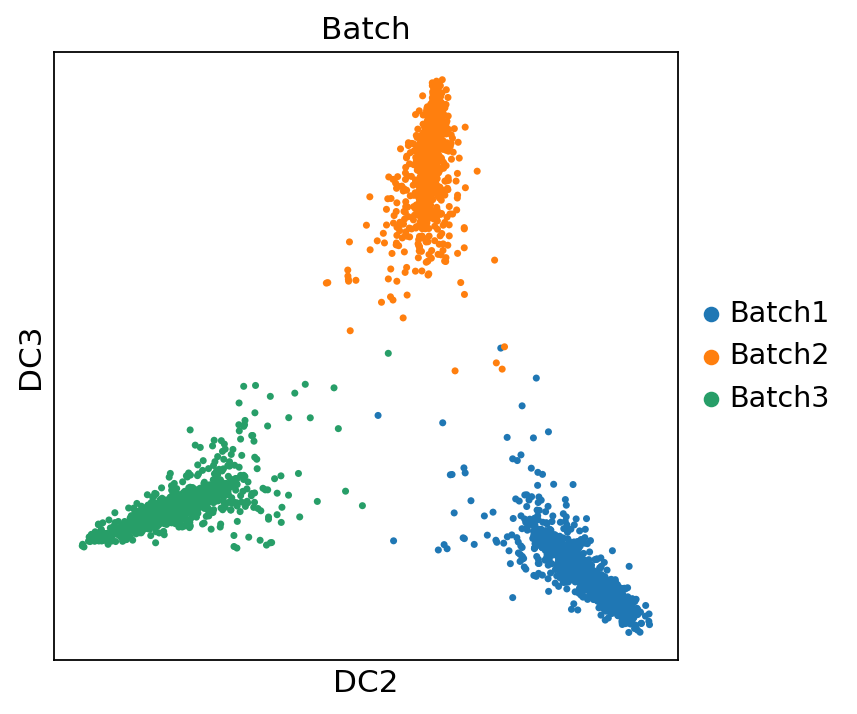

In [474]:
sc.pl.embedding(adata, basis="diffmap", components=["2,3"], color="Batch")

# micropattern

In [2]:
import numpy as np
from scipy.sparse import csr_matrix

adata = sc.read_h5ad("./adata_48_72.h5ad")
np.random.seed(1)
adata_reorder = adata[np.random.permutation(adata.shape[0]), :].copy()

In [3]:
adata_reorder.X = adata_reorder.layers["counts"].copy()
sc.pp.normalize_total(adata_reorder, target_sum=1e4)
adata_reorder.X = csr_matrix(adata_reorder.X.toarray().round())

In [113]:
scvi.settings.seed = 1  # sysvi performance depends on random seed, perhaps due to vamp prior initialization??
SysVI.setup_anndata(
    adata_reorder,
    batch_key="sample_labels",
    continuous_covariate_keys=list(
        adata_reorder.obs.columns[adata_reorder.obs.columns.str.contains("ENSG")]
    ),
)
model = SysVI(
    adata_reorder,
    prior="vamp",
    n_prior_components=4,
    n_latent=30,
    n_hidden=256,
    n_layers=2,
    out_var_mode="feature",
    encoder_decoder_kwargs={
        "inject_covariates": False,
        "use_layer_norm": False,
        "use_batch_norm": False,
        "bias": True,
    },
)
model.train(
    max_epochs=100,
    plan_kwargs={
        "z_distance_cycle_weight": 1,  # default is 2
        # "lr": 1e-3,
    },
    check_val_every_n_epoch=1,
    batch_size=int(adata_reorder.shape[0] / 2),
)
adata_reorder.obsm["scvi"] = model.get_latent_representation()

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the v

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [5]:
scvi.settings.seed = 1  # sysvi performance depends on random seed, perhaps due to vamp prior initialization??
scvi.model.SCVI.setup_anndata(
    adata_reorder,
    batch_key="sample_labels",
)
model = scvi.model.SCVI(
    adata_reorder, n_hidden=256, n_layers=2, gene_likelihood="nb", use_batch_norm="none"
)
model.train(
    max_epochs=100,
    plan_kwargs={"lr": 1e-3, "kl_weight": 100},
    check_val_every_n_epoch=1,
    batch_size=1024,
)
adata_reorder.obsm["scvi"] = model.get_latent_representation()

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


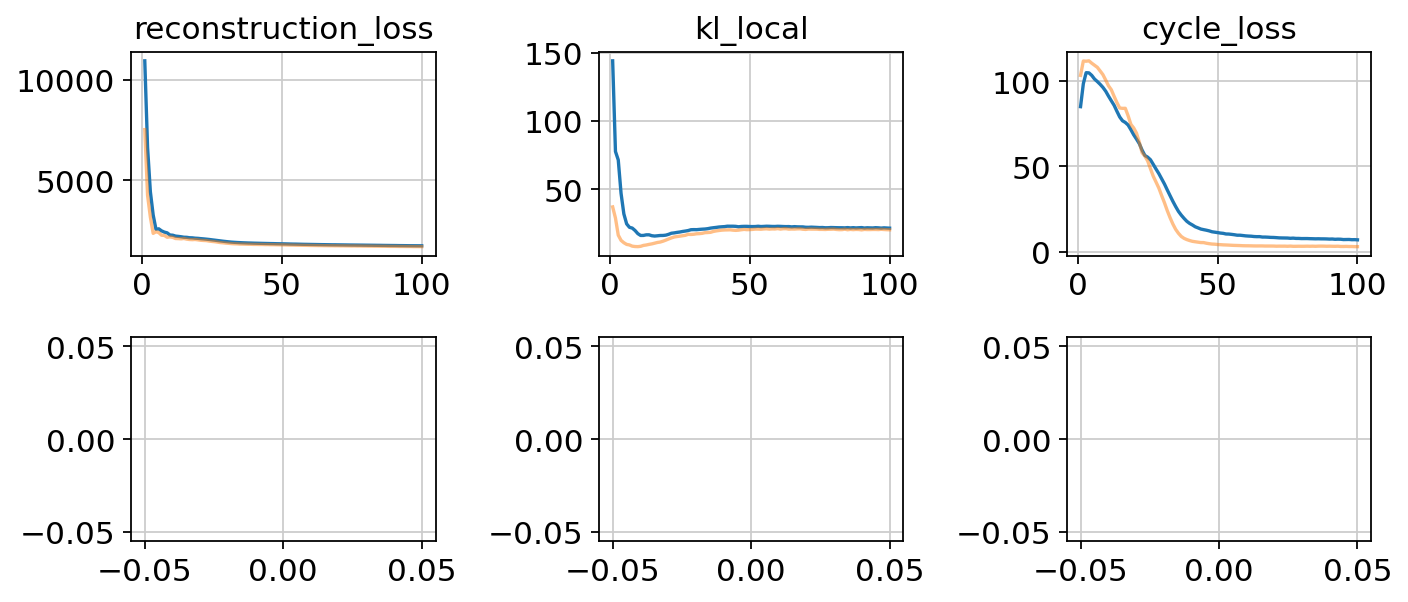

In [114]:
import matplotlib.pyplot as plt

epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(
            l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha
        )

fig.tight_layout()

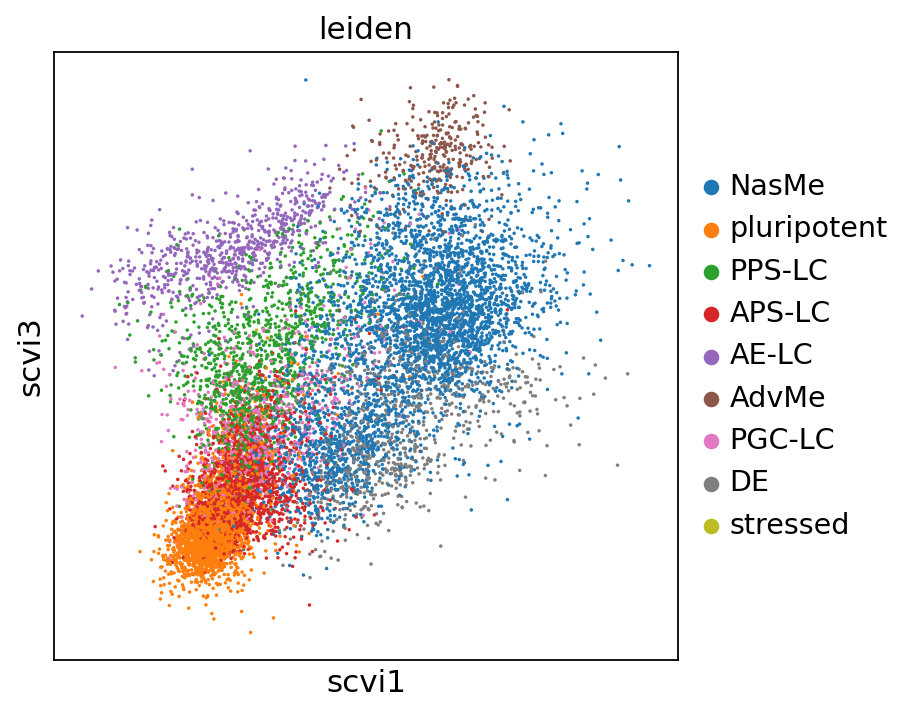

In [157]:
sc.pl.embedding(adata_reorder, basis="scvi", components=["1,3"], color="leiden")

In [140]:
sc.pp.neighbors(adata_reorder, use_rep="scvi", n_neighbors=30, method="gauss")
sc.tl.umap(adata_reorder)

.obsp["connectivities"] have not been computed using umap


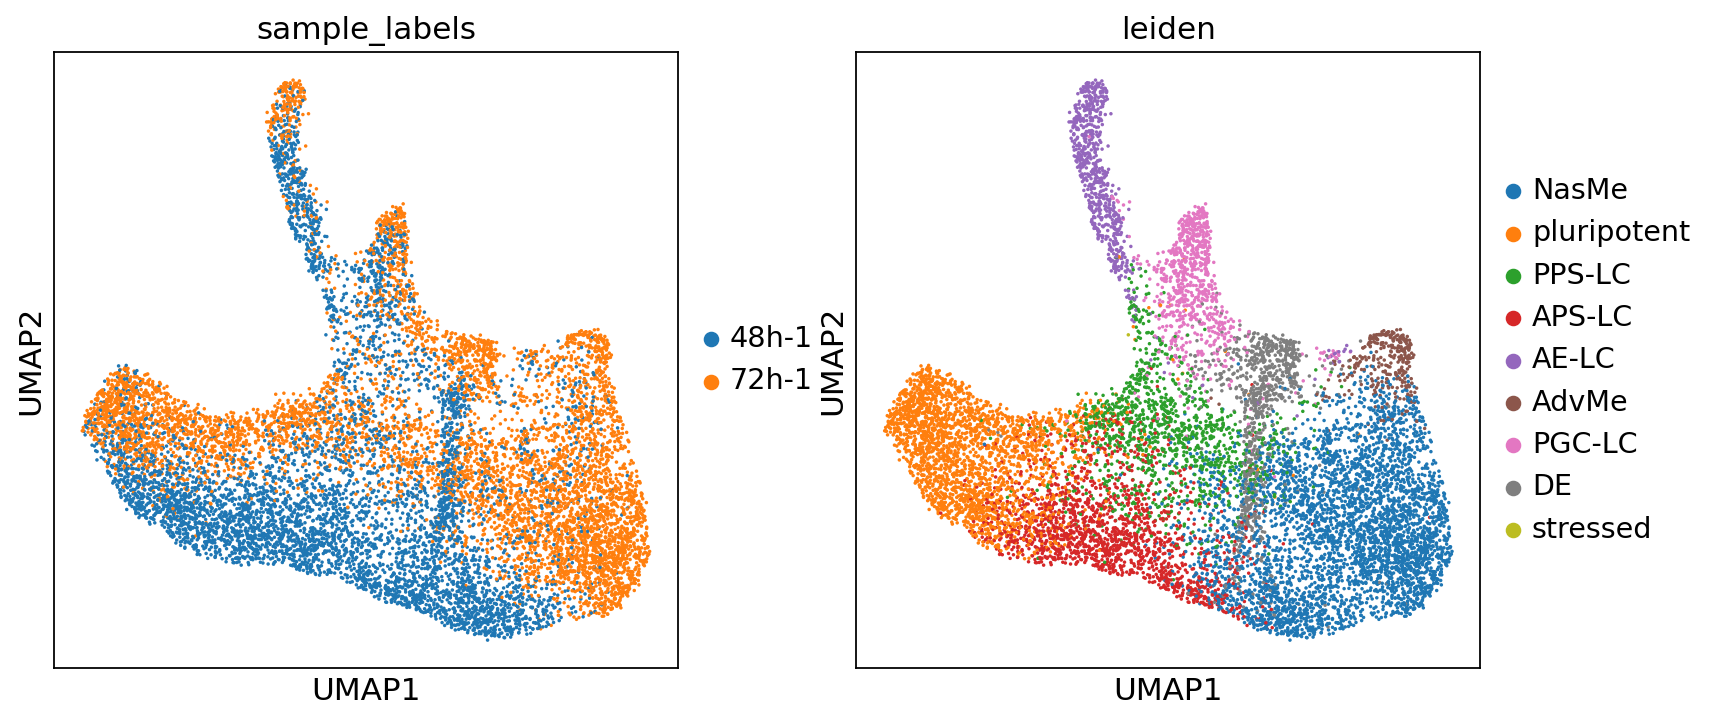

In [141]:
sc.pl.umap(adata_reorder, color=["sample_labels", "leiden"])

In [142]:
sc.tl.diffmap(adata_reorder)

In [146]:
sc.pp.neighbors(adata_reorder, use_rep="X_diffmap", key_added="nei_diff")

In [147]:
sc.tl.leiden(adata_reorder, neighbors_key="nei_diff", key_added="leiden_diff")

/tmp/ipykernel_713635/1560284842.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_reorder, neighbors_key="nei_diff", key_added="leiden_diff")


In [41]:
adata_reorder = sc.read_h5ad("./adata_48_72_sysvi.h5ad")

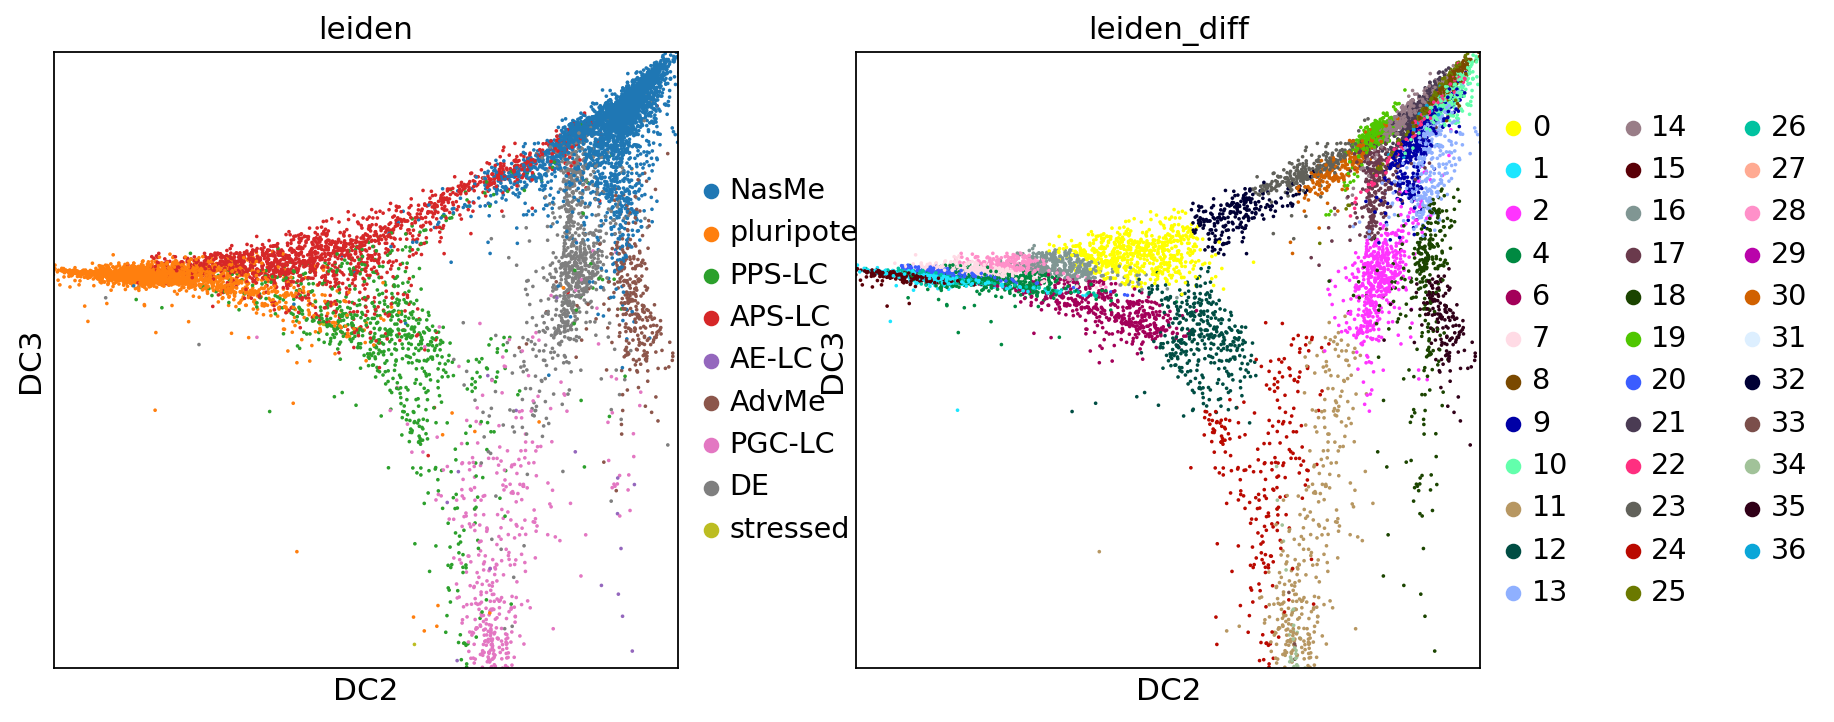

In [42]:
axes = sc.pl.diffmap(
    # adata_reorder[adata_reorder.obs["leiden"].str.contains("PS|DE|PGC")],
    adata_reorder[~adata_reorder.obs["leiden_diff"].str.contains("^3$|^5$")],
    components=["2,3"],
    color=["leiden", "leiden_diff"],
    show=False,
)
for ax in axes:
    points = ax.collections[0].get_offsets().data
    ax.set_xlim(np.percentile(points[:, 0], [0.1, 99.9]))
    ax.set_ylim(np.percentile(points[:, 1], [10, 99.9]))

In [ ]:
adata_sub = adata_reorder[
    ~adata_reorder.obs["leiden_diff"].str.contains("^3$|^5$")
].copy()

In [49]:
adata_sub.obs["48h"] = None
adata_sub.obs.loc[adata_sub.obs["sample_labels"].str.contains("48h"), "48h"] = (
    adata_sub.obs.loc[adata_sub.obs["sample_labels"].str.contains("48h"), "leiden"]
)
adata_sub.obs["72h"] = None
adata_sub.obs.loc[adata_sub.obs["sample_labels"].str.contains("72h"), "72h"] = (
    adata_sub.obs.loc[adata_sub.obs["sample_labels"].str.contains("72h"), "leiden"]
)

In [53]:
adata_sub.obs["leiden"].cat.categories

Index(['NasMe', 'pluripotent', 'PPS-LC', 'APS-LC', 'AE-LC', 'AdvMe', 'PGC-LC',
       'DE', 'stressed'],
      dtype='object')

In [57]:
cmap = dict(zip(adata_sub.obs["leiden"].cat.categories, adata_sub.uns["leiden_colors"]))

/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


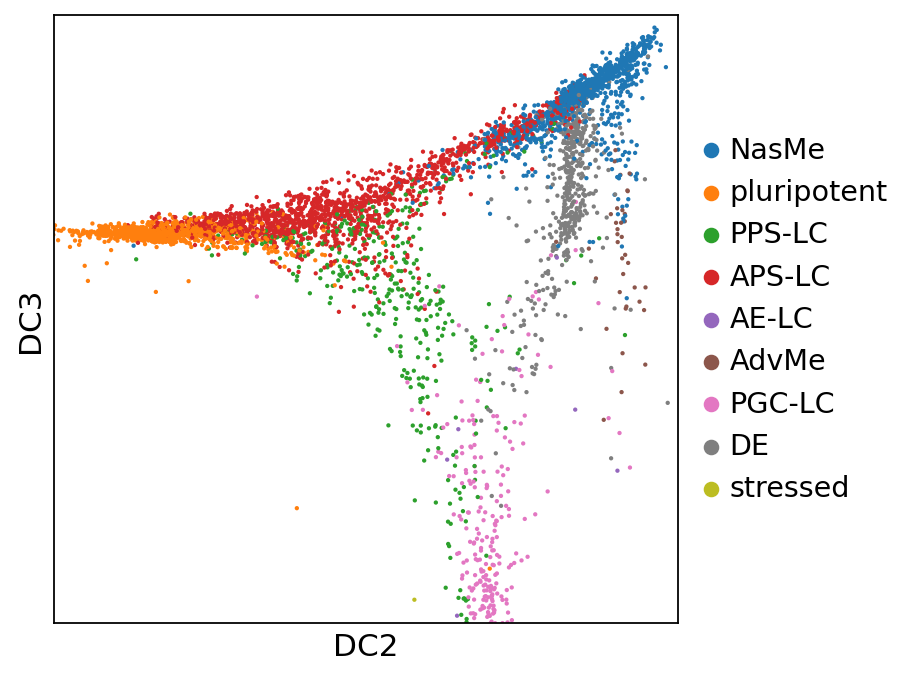

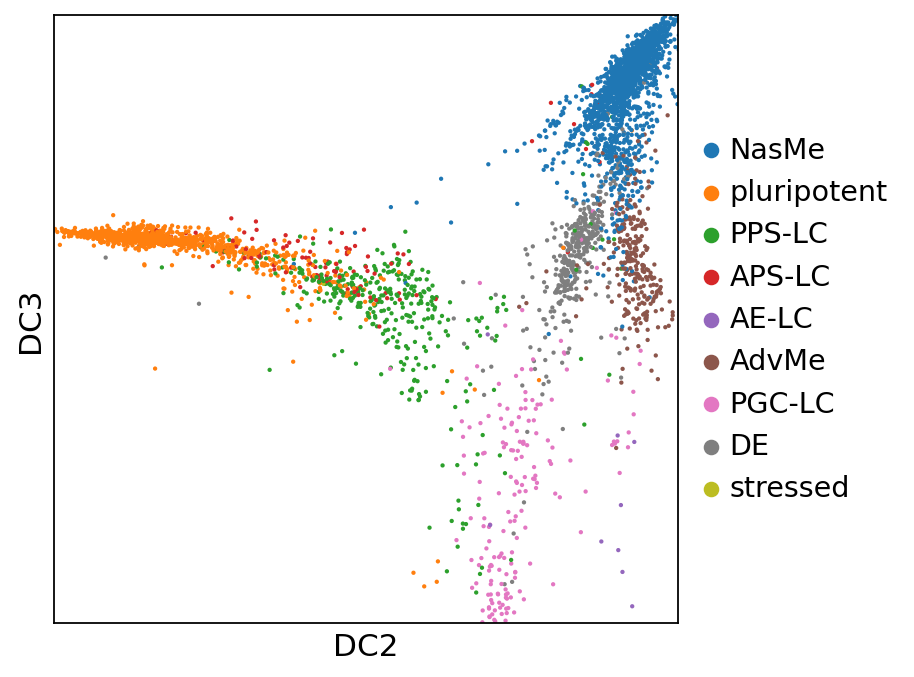

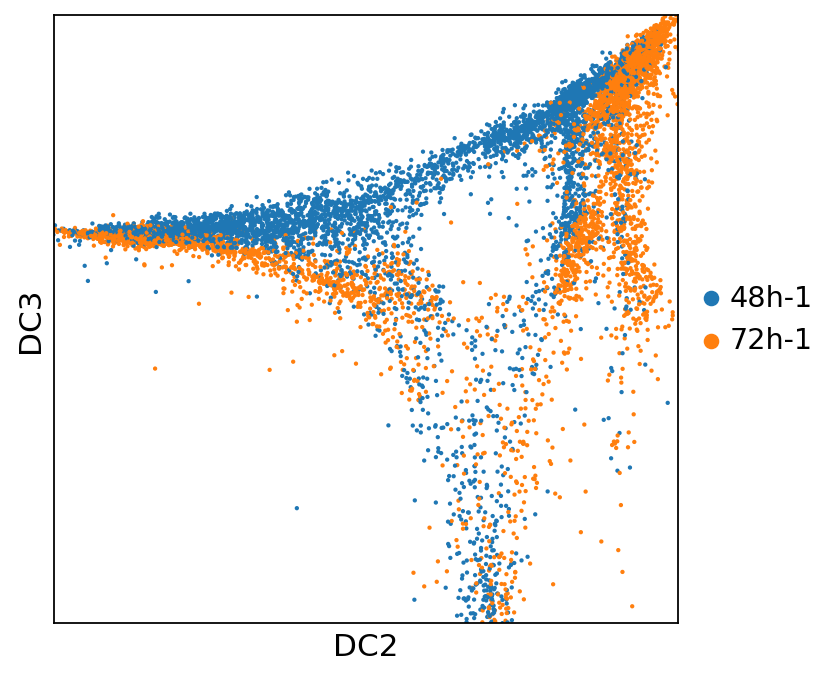

In [59]:
ax = sc.pl.embedding(
    adata_sub[adata_sub.obs["sample_labels"].str.contains("48h")],
    basis="X_diffmap",
    color=["leiden"],
    components="2,3",
    # legend_loc="on data",
    size=15,
    show=False,
    cmap="YlGn",
    na_in_legend=False,
    palette=cmap,
    frameon=True,
    title=["", ""],
    # xlim=[0, 100]
)
ax.set_xlabel("DC2")
ax.set_ylabel("DC3")
ax.set_xlim(np.percentile(points[:, 0], [0.1, 99.9]))
ax.set_ylim(np.percentile(points[:, 1], [10, 99.9]))
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/vae_micropattern_annotation_1.png",
    dpi=300,
    bbox_inches="tight",
)

ax = sc.pl.embedding(
    adata_sub[adata_sub.obs["sample_labels"].str.contains("72h")],
    basis="X_diffmap",
    color=["leiden"],
    components="2,3",
    # legend_loc="on data",
    size=15,
    show=False,
    cmap="YlGn",
    na_in_legend=False,
    palette=cmap,
    frameon=True,
    title=["", ""],
    # xlim=[0, 100]
)
ax.set_xlabel("DC2")
ax.set_ylabel("DC3")
ax.set_xlim(np.percentile(points[:, 0], [0.1, 99.9]))
ax.set_ylim(np.percentile(points[:, 1], [10, 99.9]))
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/vae_micropattern_annotation_2.png",
    dpi=300,
    bbox_inches="tight",
)

np.random.seed(1)
ax = sc.pl.embedding(
    adata_sub,
    basis="X_diffmap",
    color=["sample_labels"],
    components="2,3",
    # legend_loc="on data",
    size=15,
    show=False,
    cmap="YlGn",
    na_in_legend=False,
    frameon=True,
    title=["", ""],
    # xlim=[0, 100]
)
ax.set_xlabel("DC2")
ax.set_ylabel("DC3")
ax.set_xlim(np.percentile(points[:, 0], [0.1, 99.9]))
ax.set_ylim(np.percentile(points[:, 1], [10, 99.9]))
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/vae_micropattern_annotation_sample.png",
    dpi=300,
    bbox_inches="tight",
)

In [161]:
adata_reorder.write_h5ad("./adata_48_72_sysvi.h5ad")

# monkey mouse

In [26]:
import numpy as np
from scipy.sparse import csr_matrix

adata = sc.read_h5ad("./monkey_mouse_integrate_loop.h5ad")
np.random.seed(1)
adata_reorder = adata[np.random.permutation(adata.shape[0]), :].copy()

In [27]:
adata_reorder.X = adata_reorder.layers["counts"].copy()
sc.pp.normalize_total(adata_reorder, target_sum=1e4)
adata_reorder.X = csr_matrix(adata_reorder.X.toarray().round())

In [36]:
scvi.settings.seed = 1  # sysvi performance depends on random seed, perhaps due to vamp prior initialization??
SysVI.setup_anndata(
    adata_reorder,
    batch_key="species",
    categorical_covariate_keys=["sample_labels"],
    continuous_covariate_keys=list(adata_reorder.obs.columns[26:46]),
)
model = SysVI(
    adata_reorder,
    prior="vamp",
    n_prior_components=8,
    n_latent=30,
    n_hidden=256,
    n_layers=2,
    out_var_mode="sample_feature",
    encoder_decoder_kwargs={
        "inject_covariates": False,
        "use_layer_norm": False,
        "use_batch_norm": False,
        "bias": True,
    },
)
model.train(
    max_epochs=100,
    plan_kwargs={
        "z_distance_cycle_weight": 2,  # default is 2
    },
    check_val_every_n_epoch=1,
    batch_size=1024 * 10,
)
adata_reorder.obsm["scvi"] = model.get_latent_representation()

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the v

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [58]:
adata_manager = model.get_anndata_manager(adata_reorder)
adata_manager.view_registry()

Anndata setup with scvi-tools version 1.3.3.

Setup via `SysVI.setup_anndata` with arguments:

{
│   'batch_key': 'species',
│   'layer': None,
│   'categorical_covariate_keys': ['sample_labels'],
│   'continuous_covariate_keys': [],
│   'weight_batches': False
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 98434 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│          n_vars          │ 1850  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
└────────────────────────┴────────────────────────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['species'] │   monkey   │          0          │
│                      │   mouse    │          1          │
└──────────────────────┴────────────┴─────────────────────┘

              extra_categorical_covs State Registry              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location       ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_labels'] │     1      │          0          │
│                            │     2      │          1          │
│                            │     3      │          2          │
│                            │     4      │          3          │
│                            │     5      │          4          │
│                            │     6      │          5          │
│                            │     7      │          6          │
│                            │     8      │          7          │
│                            │     9      │          8          │
│                            │     10     │          9          │
│                            │     12     │         10          │
│                            │     13     │         11          │
│                            │     14     │         12          │
│                            │     15     │         13          │
│                            │     16     │         14          │
│                            │     17     │         15          │
│                            │     18     │         16          │
│                            │     19     │         17          │
│                            │     20     │         18          │
│                            │     23     │         19          │
│                            │     24     │         20          │
│                            │     25     │         21          │
│                            │     26     │         22          │
│                            │     27     │         23          │
│                            │     28     │         24          │
│                            │     29     │         25          │
│                            │     30     │         26          │
│                            │     31     │         27          │
│                            │     32     │         28          │
│                            │     33     │         29          │
│                            │     34     │         30          │
│                            │     35     │         31          │
│                            │     36     │         32          │
│                            │     37     │         33          │
│                            │   CS8-e1   │         34          │
│                            │   CS8-e2   │         35          │
│                            │   CS9-e1   │         36          │
│                            │   CS9-e2   │         37          │
│                            │  CS11-e1   │         38          │
│                            │  CS11-e2   │         39          │
│                            │            │                     │
└────────────────────────────┴────────────┴─────────────────────┘

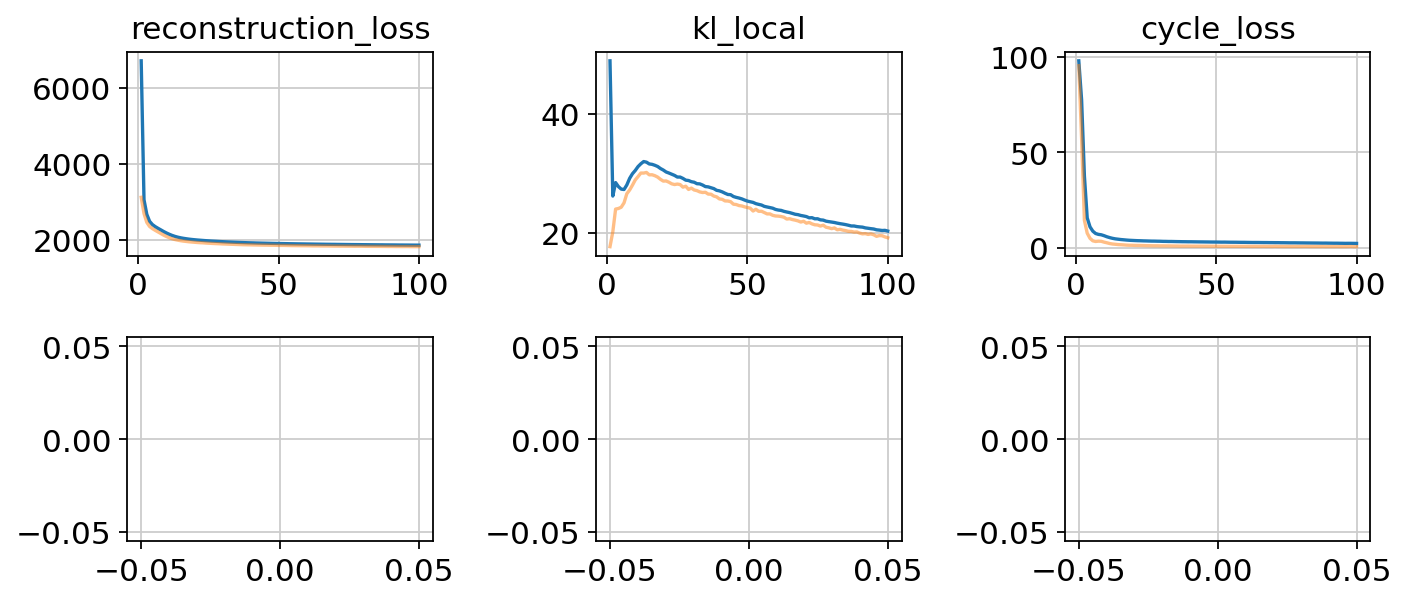

In [37]:
import matplotlib.pyplot as plt

epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(
            l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha
        )

fig.tight_layout()

In [30]:
adata_reorder.write_h5ad("./adata_monkey_mouse_sysvi.h5ad")

In [1]:
import scanpy as sc

In [2]:
adata_reorder = sc.read_h5ad("./adata_monkey_mouse_sysvi.h5ad")

In [23]:
sc.external.pp.bbknn(
    adata_reorder, batch_key="species", use_rep="scvi", neighbors_within_batch=15
)

consider updating your call to make use of `computation`


In [24]:
sc.tl.umap(adata_reorder)

In [38]:
sc.pp.neighbors(
    adata_reorder, use_rep="scvi", n_neighbors=15, key_added="nei_scvi", method="gauss"
)
sc.tl.umap(adata_reorder, neighbors_key="nei_scvi")

.obsp["nei_scvi_connectivities"] have not been computed using umap


In [40]:
sc.pl.umap(adata_reorder, color=["cell_type", "celltype"], ncols=1)

In [4]:
sc.external.pp.harmony_integrate(
    adata_reorder, key="species", basis="scvi", adjusted_basis="scvi_harmony"
)

2025-09-09 03:51:03,723 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-09 03:51:18,294 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-09 03:51:18,821 - harmonypy - INFO - Iteration 1 of 10
2025-09-09 03:52:22,174 - harmonypy - INFO - Iteration 2 of 10
2025-09-09 03:53:23,935 - harmonypy - INFO - Iteration 3 of 10
2025-09-09 03:54:24,828 - harmonypy - INFO - Iteration 4 of 10
2025-09-09 03:55:28,250 - harmonypy - INFO - Iteration 5 of 10
2025-09-09 03:56:33,244 - harmonypy - INFO - Iteration 6 of 10
2025-09-09 03:57:36,609 - harmonypy - INFO - Iteration 7 of 10
2025-09-09 03:58:39,111 - harmonypy - INFO - Iteration 8 of 10
2025-09-09 03:59:42,128 - harmonypy - INFO - Iteration 9 of 10
2025-09-09 04:00:46,260 - harmonypy - INFO - Iteration 10 of 10
2025-09-09 04:01:25,341 - harmonypy - INFO - Converged after 10 iterations


In [6]:
sc.pp.neighbors(
    adata_reorder,
    use_rep="scvi_harmony",
    n_neighbors=15,
    key_added="nei_scvi",
    method="gauss",
)
sc.tl.umap(adata_reorder, neighbors_key="nei_scvi")

.obsp["nei_scvi_connectivities"] have not been computed using umap


In [22]:
sc.pl.umap(adata_reorder, color=["cell_type", "celltype"], ncols=1)

In [ ]:
sc.pp.neighbors(
    adata_reorder,
    use_rep="scvi_harmony",
    n_neighbors=20,
    key_added="nei_scvi",
    method="gauss",
)
sc.tl.diffmap(adata_reorder, neighbors_key="nei_scvi", n_comps=25)

In [ ]:
sc.set_figure_params(figsize=(5, 5))

In [26]:
sc.pl.diffmap(
    adata_reorder, color=["cell_type", "celltype"], ncols=1, components=["5,6"]
)

In [29]:
import pathlib
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np

save_dir = pathlib.Path("./img_dump/monkey_diffmap_sysvi")
save_dir.mkdir(exist_ok=True, parents=True)
overwrite = True

for i, j in combinations(range(25), 2):
    if overwrite or not (save_dir / f"diffmap_{i}_{j}.png").exists():
        adata_sub = adata_reorder[
            np.logical_or(
                adata_reorder.obs["cell_type"].str.contains(
                    "Para.Meso|PSM|NMP|Nas|EPI|^PS", na=False
                ),
                adata_reorder.obs["celltype"].str.contains(
                    "Epi|^Primi|Nascent|Somitic|Paraxial|Caudal|NMP", na=False
                ),
            )
        ]
        axes = sc.pl.embedding(
            adata_sub,
            basis="X_diffmap",
            color=["cell_type", "celltype"],
            components=f"{i + 1},{j + 1}",
            # legend_loc="on data",
            ncols=2,
            size=50,
            show=False,
            na_in_legend=False,
            frameon=False,
            title=["", ""],
            # xlim=[0, 100]
        )
        for ax in axes:
            ax.set_xlim(np.percentile(adata_sub.obsm["X_diffmap"][:, i], [0.1, 99.9]))
            ax.set_ylim(np.percentile(adata_sub.obsm["X_diffmap"][:, j], [0.1, 99.9]))
        plt.savefig(
            save_dir / f"diffmap_{i + 1}_{j + 1}.png", dpi=100, bbox_inches="tight"
        )
        plt.close()

In [33]:
monkey_cmap = dict(zip(adata_reorder.obs["cell_type"], adata_reorder.obs["color"]))
mouse_cmap = dict(
    zip(adata_reorder.obs["celltype"], "#" + adata_reorder.obs["colour"].astype(str))
)

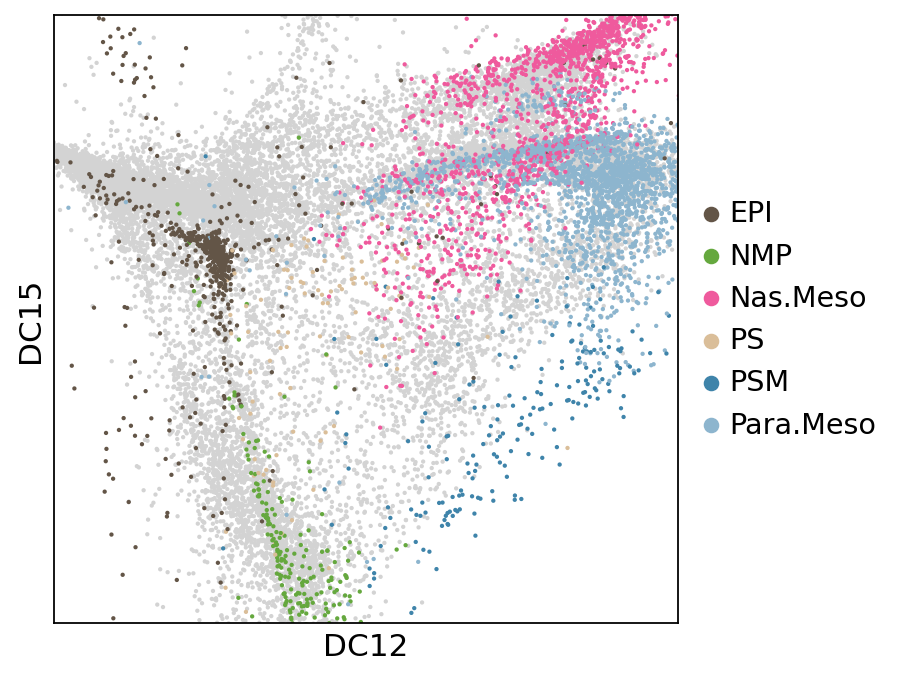

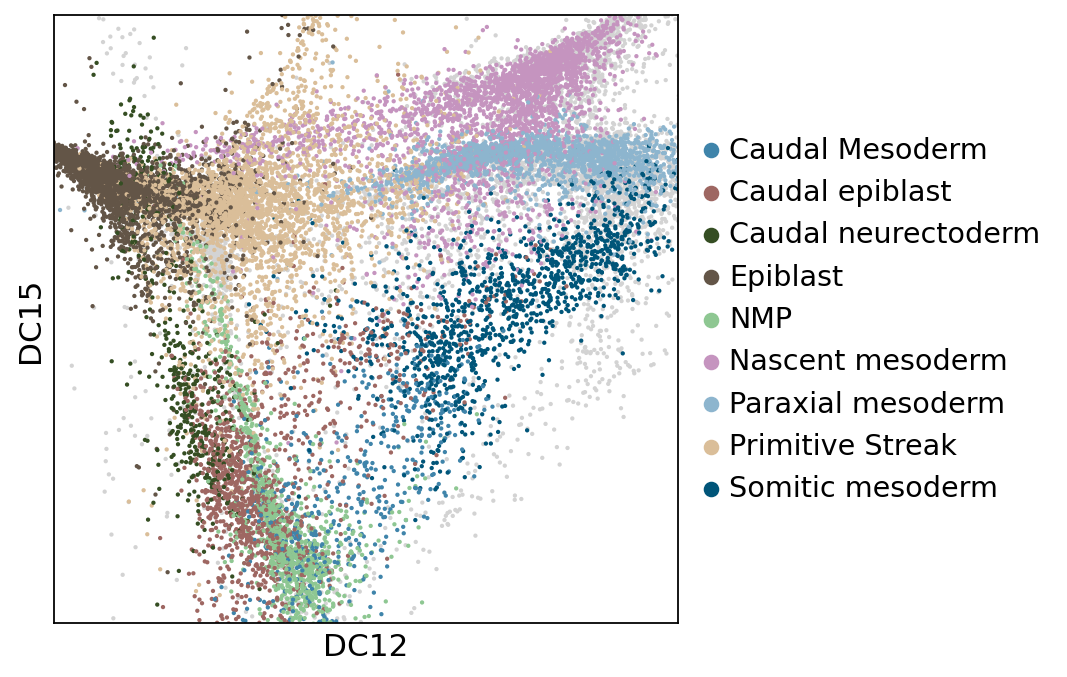

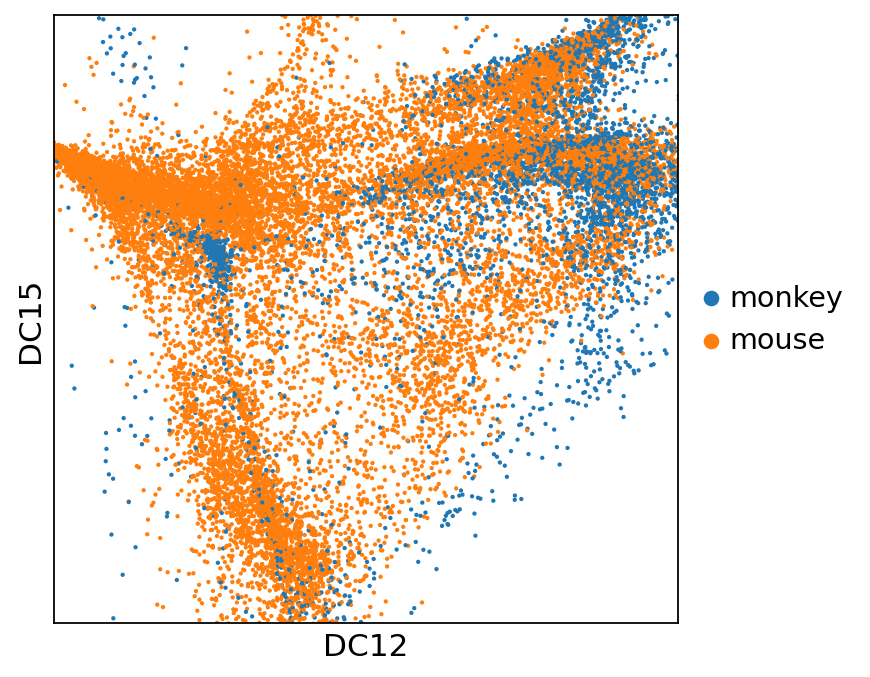

In [40]:
ax = sc.pl.embedding(
    adata_sub,
    basis="X_diffmap",
    color=["cell_type"],
    components="12,15",
    # legend_loc="on data",
    size=15,
    show=False,
    cmap="YlGn",
    na_in_legend=False,
    palette=monkey_cmap,
    frameon=True,
    title=["", ""],
    # xlim=[0, 100]
)
ax.set_xlabel("DC12")
ax.set_ylabel("DC15")
ax.set_xlim(np.percentile(adata_sub.obsm["X_diffmap"][:, 11], [1, 99]))
ax.set_ylim(np.percentile(adata_sub.obsm["X_diffmap"][:, 14], [1, 99]))
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/vae_monkey_somite_loop_annotation.png",
    dpi=300,
    bbox_inches="tight",
)

ax = sc.pl.embedding(
    adata_sub,
    basis="X_diffmap",
    color=["celltype"],
    components="12,15",
    # legend_loc="on data",
    size=15,
    show=False,
    cmap="YlGn",
    na_in_legend=False,
    palette=mouse_cmap,
    frameon=True,
    title=["", ""],
    # xlim=[0, 100]
)
ax.set_xlabel("DC12")
ax.set_ylabel("DC15")
ax.set_xlim(np.percentile(adata_sub.obsm["X_diffmap"][:, 11], [1, 99]))
ax.set_ylim(np.percentile(adata_sub.obsm["X_diffmap"][:, 14], [1, 99]))
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/vae_mouse_somite_loop_annotation.png",
    dpi=300,
    bbox_inches="tight",
)

np.random.seed(1)
ax = sc.pl.embedding(
    adata_sub[np.random.permutation(adata_sub.shape[0]), :],
    basis="X_diffmap",
    color=["species"],
    components="12,15",
    # legend_loc="on data",
    size=15,
    show=False,
    cmap="YlGn",
    na_in_legend=False,
    frameon=True,
    title=["", ""],
    # xlim=[0, 100]
)
ax.set_xlabel("DC12")
ax.set_ylabel("DC15")
ax.set_xlim(np.percentile(adata_sub.obsm["X_diffmap"][:, 11], [1, 99]))
ax.set_ylim(np.percentile(adata_sub.obsm["X_diffmap"][:, 14], [1, 99]))
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/vae_somite_loop_species.png",
    dpi=300,
    bbox_inches="tight",
)